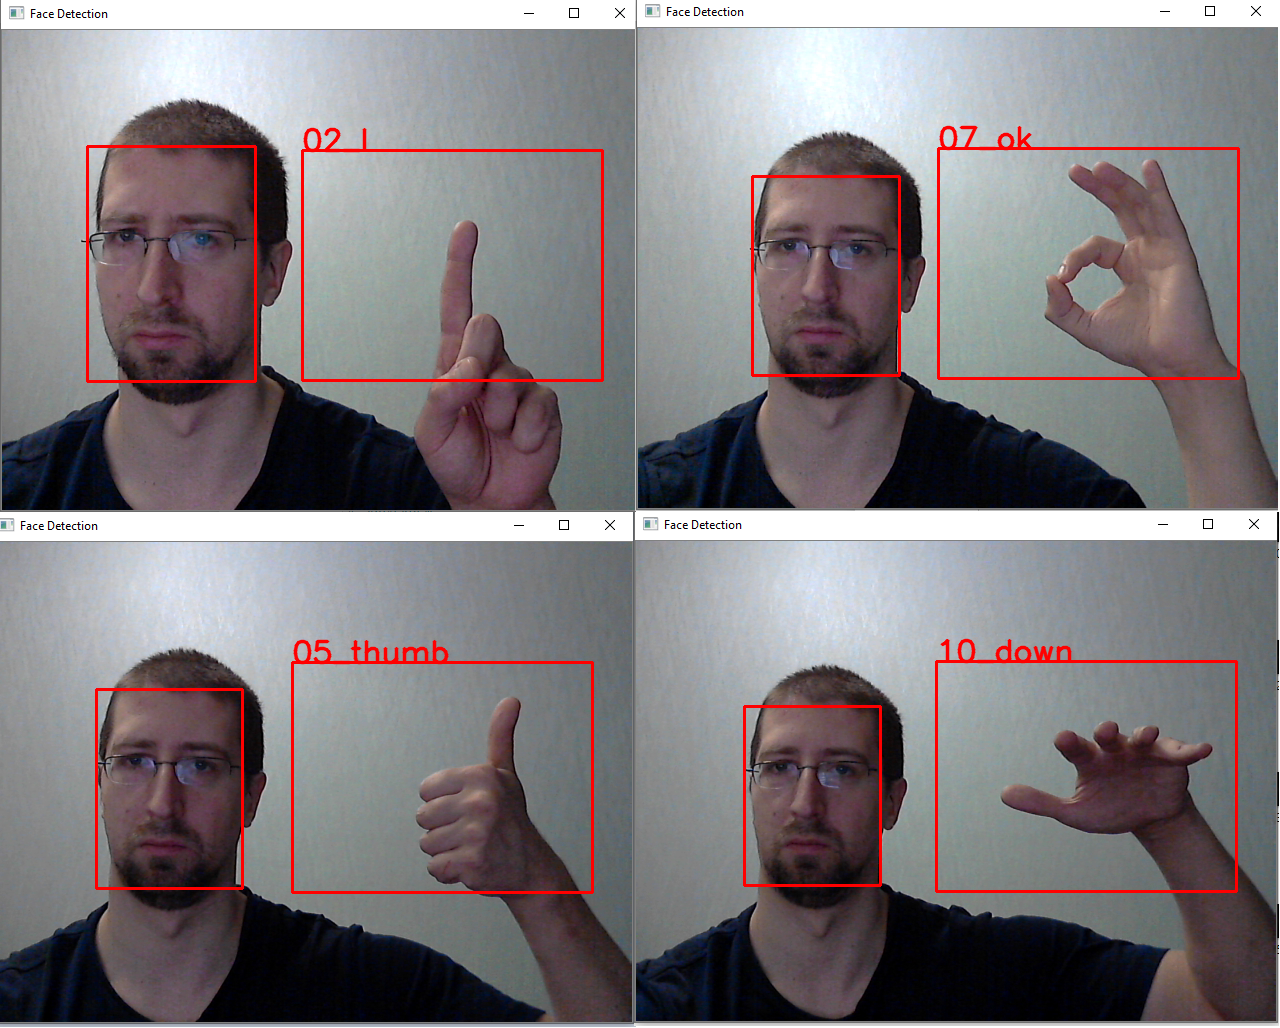

In [99]:
from IPython.display import Image
Image("./test.png")

### 1.1 Загрузка Датасета

In [1]:
import numpy as np
import pandas as pd
import sys, os
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [3]:
gest_path = []
gest_label = []


for root, dirs, files in os.walk('D:\leapGestRecog'):
    for name in files:
        f = os.path.join(root, name)
        gest_path.append(f)
        gest_label.append(int(f[20:22]) - 1)

df = pd.DataFrame({'path': gest_path, 'label': gest_label})
df.head(3)

,path,label
0,D:\leapGestRecog\00\01_palm\frame_00_01_0001.png,0
1,D:\leapGestRecog\00\01_palm\frame_00_01_0002.png,0
2,D:\leapGestRecog\00\01_palm\frame_00_01_0003.png,0


In [4]:
dict_labels =  {0: 'palm', 1: 'l', 2: 'fist', 
                3: 'fist_moved', 4: 'thumb', 5: 'index', 
                6: 'ok', 7: 'palm_moved', 8: 'c', 9: 'down'}

### 1.2 Формирование датасета для передачи в модель

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_info, transform):
        self.data_info = data_info
        self.image_arr = self.data_info.iloc[:, 0]
        self.image_label = self.data_info.iloc[:, 1]
        self.transform = transform
        self.data_len = len(data_info.index)
        
    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        #open image, apply transforms and return with label
        image = Image.open(self.image_arr[idx])  # PIL image
        image = self.transform(image)
        return image, self.image_label[idx]
    
    
    
train_transformer = transforms.Compose([
                    transforms.Resize(64),              # resize the image to 64x64 
                    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
                    transforms.ToTensor()])             # transform it into a PyTorch Tensor

val_transformer =   transforms.Compose([
                    transforms.Resize(64),              # resize the image to 64x64 
                    transforms.ToTensor()])             # transform it into a PyTorch Tensor



In [6]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDataset(X_train, train_transformer)
test_data = CustomDataset(X_test, val_transformer)

In [7]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

### 2.1 Создание модели

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        #self.fc1 = nn.Linear(37524, 128)
        self.fc1 = nn.Linear(2490 * 32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #print(x.size())
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [9]:
net = Net().to('cuda')

In [10]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
len(train_data_loader)

14000

In [12]:
# for epoch in range(5):
#     running_loss = 0.0
#     for i, data in enumerate(train_data_loader, 0):
#         inputs, labels = data[0].cuda(), data[1].cuda()
        
#         optimizer.zero_grad()
        
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         if i % 300 == 0:    # печатаем каждые 300 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 300))
#             running_loss = 0.0
    
# print('Training is finished!')

In [13]:
savePATH = './selfLastModel.pth'
#torch.save(net.state_dict(), savePATH)

In [14]:
net = Net().to('cuda')
net.load_state_dict(torch.load(savePATH))

<All keys matched successfully>

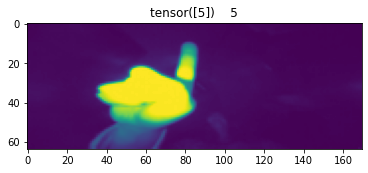

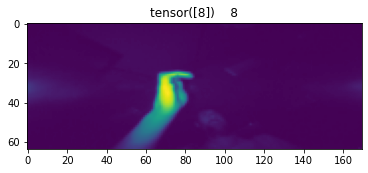

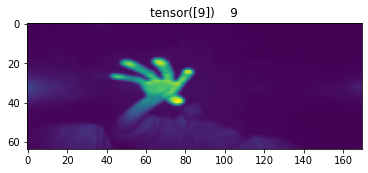

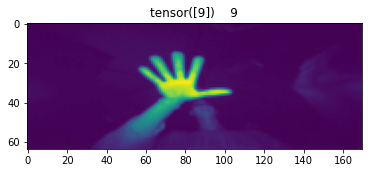

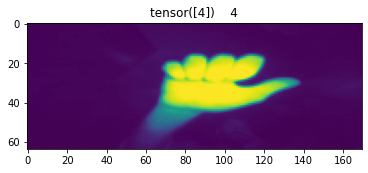

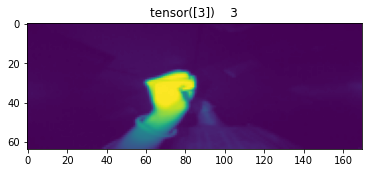

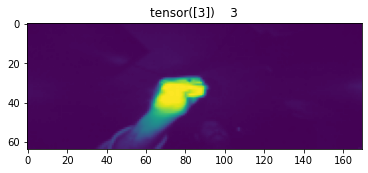

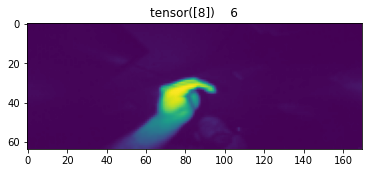

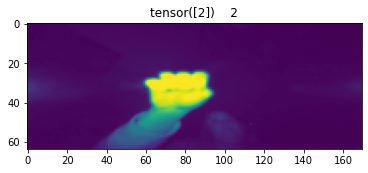

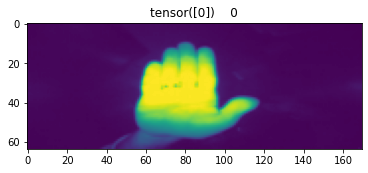

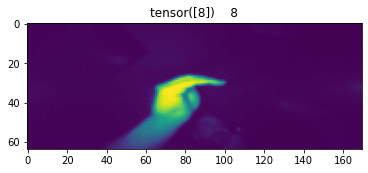

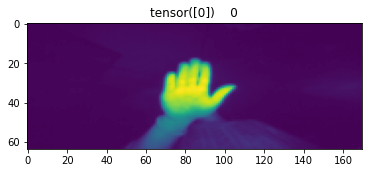

In [24]:
for i, data in enumerate(test_data_loader, 0):
    inputs, labels = data[0].cuda(), data[1].cuda()
    res = net(inputs)
    #print(res)
    #print(np.argmax(res.detach().cpu().numpy()))
    
    f, axarr = plt.subplots(1,1)
    
    
    axarr.imshow(inputs[0,0,:,:].cpu())
    plt.title(f'{data[1]}    {np.argmax(res.detach().cpu().numpy())}')
    #print(f'{data[1]}    {np.argmax(res.detach().cpu().numpy())}')
    #print('true: ', data[1])
    
      
    if i>10:
        break

In [43]:
res.detach().cpu().numpy().argmax()

0

### 2. Проверка модели на видео

In [97]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

# Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
cap = cv2.VideoCapture(0)  

# Класс детектирования и обработки лица с веб-камеры 
class FaceDetector(object):

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = Net().to(self.device)
        self.emodel.load_state_dict(torch.load('./selfLastModel.pth'))
        self.emodel.eval()

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, landmarks, prediction=' '):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

#                 # пишем на кадре какая эмоция распознана
                
                cv2.putText(frame, 
                    prediction, (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

#                 # Рисуем особенные точки
#                 cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
#                 cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
#                 cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
#                 cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
#                 cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            print('Something wrong im draw function!')

        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return '01_palm'
        elif digit == 1:
            return '02_l'
        elif digit == 2:
            return '03_fist'
        elif digit == 3:
            return '04_fist_moved'
        elif digit == 4:
            return '05_thumb'
        elif digit == 5:
            return '06_index'
        elif digit == 6:
            return '07_ok'
        elif digit == 7:
            return '08_palm_moved'
        elif digit == 8:
            return '09_c'
        elif digit == 9:
            return '10_down'
    
    
    
    
    
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                # и особенные точки лица
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
                
                
#                 # Вырезаем лицо из кадра
#                 face = self.crop_faces(frame, boxes)[0]
#                 # Меняем размер изображения лица для входа в нейронную сеть
#                 face = cv2.resize(face,(170,64))
#                 # Превращаем в 1-канальное серое изображение
#                 face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
#                 print(face.shape)
#                 # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
#                 torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
#                 print(torch_face.size())
                
                               
#                 # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
#                 emotion = self.emodel(torch_face[None, ...])
#                 # Интерпретируем предсказание как строку нашей эмоции
#                 emotion = self.digit_to_classname(emotion.argmax())

                # Рисуем на кадре
                self._draw(frame, boxes, probs, landmarks)
                
                gesture_boxes = [[300, 120, 600, 350]]
                gesture_img = self.crop_faces(frame, gesture_boxes)[0]
                gesture_img = cv2.resize(gesture_img, (170, 64))
                gesture_img = cv2.cvtColor(gesture_img, cv2.COLOR_BGR2GRAY)
                
                torch_gesture = torch.from_numpy(gesture_img).unsqueeze(0).to(self.device).float()
                
                gest_predict = self.emodel(torch_gesture[None, ...])
                #print(gest_predict)
                
                gest_predict = self.digit_to_classname(gest_predict.detach().cpu().numpy().argmax())
                #print(gest_predict)
                                
                
                self._draw(frame, gesture_boxes, probs, landmarks, gest_predict)
            
                

            except Exception as e:
                print('Something wrong im main cycle!')
                print(e)

            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2.imshow('Face Detection', frame)
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        cap.release()
        cv2.destroyAllWindows()
        
        
# Загружаем мтцнн
mtcnn = MTCNN()
# Создаем объект нашего класса приложения
fcd = FaceDetector(mtcnn)
# Запускаем
fcd.run()

<ipython-input-97-b84de56c59b4>:24: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(frame,
<ipython-input-97-b84de56c59b4>:32: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.putText(frame,


Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
Something wrong im draw function!
